<a href="https://colab.research.google.com/github/haris-lutafullah/Research-Work/blob/main/Traffic_Prediction_System_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#<p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 1px; color:#207d06; font-size:100%; text-align:left;padding: 0px; border-bottom: 3px solid #207d06;">**Importing Library Files**</p>

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.arima.model import ARIMA
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from prettytable import PrettyTable
from sklearn.neighbors import KNeighborsRegressor
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


#<p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 1px; color:#207d06; font-size:100%; text-align:left;padding: 0px; border-bottom: 3px solid #207d06;">**Pre-Processing**</p>

Correlation Matrix:
                      holiday      temp   rain_1h   snow_1h  clouds_all  \
holiday              1.000000  0.004646  0.000177  0.000863    0.007506   
temp                 0.004646  1.000000  0.009069 -0.019755   -0.101976   
rain_1h              0.000177  0.009069  1.000000 -0.000090    0.004818   
snow_1h              0.000863 -0.019755 -0.000090  1.000000    0.027931   
clouds_all           0.007506 -0.101976  0.004818  0.027931    1.000000   
weather_main        -0.001831 -0.033441  0.009535  0.036637    0.500745   
weather_description  0.000485 -0.049434  0.010774  0.005101   -0.341891   
traffic_volume       0.038057  0.130299  0.004714  0.000733    0.067054   

                     weather_main  weather_description  traffic_volume  
holiday                 -0.001831             0.000485        0.038057  
temp                    -0.033441            -0.049434        0.130299  
rain_1h                  0.009535             0.010774        0.004714  
snow_1h     

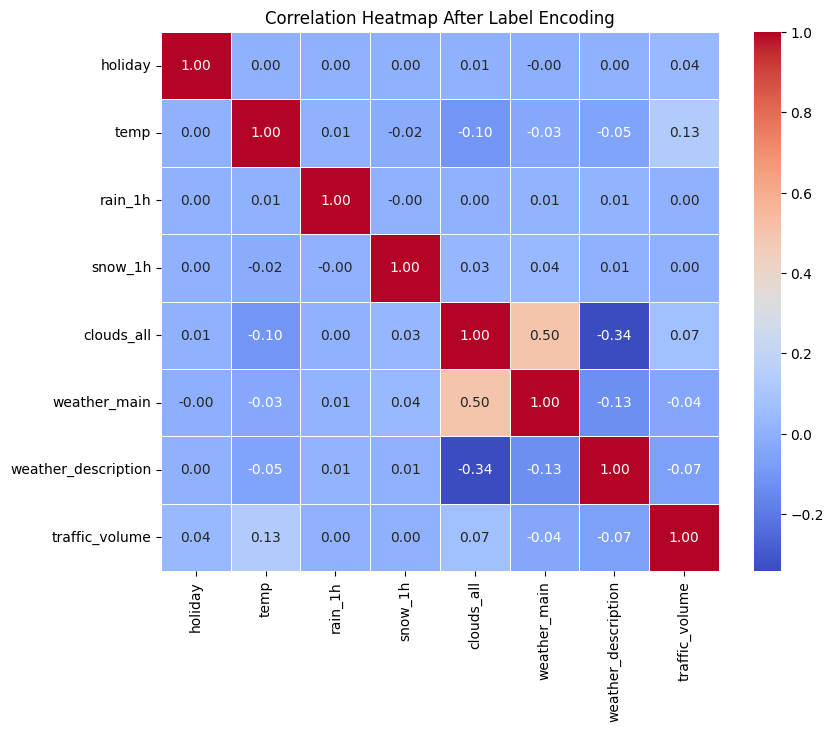

In [6]:

df = pd.read_csv("Metro_Interstate_Traffic_Volume.csv")
df['date_time'] = pd.to_datetime(df['date_time'])
df.set_index('date_time', inplace=True)

# Label Encoding
label_encoders = {}
categorical_cols = ['holiday', 'weather_main', 'weather_description']
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Handle outliers using IQR
Q1 = df['traffic_volume'].quantile(0.25)
Q3 = df['traffic_volume'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df = df[(df['traffic_volume'] >= lower_bound) & (df['traffic_volume'] <= upper_bound)]


# Compute correlation matrix
correlation_matrix = df.corr()

# Display the correlation matrix
print("Correlation Matrix:")
print(correlation_matrix)

# Plot heatmap
plt.figure(figsize=(9, 7))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap After Label Encoding")
plt.show()

# Create lag features
for lag in range(1, 4):  # 3 lag features
    df[f'lag_{lag}'] = df['traffic_volume'].shift(lag)
df.dropna(inplace=True)

# Normalize features
scaler = MinMaxScaler()
df[df.columns] = scaler.fit_transform(df)
traffic_scaler = MinMaxScaler()
df['traffic_volume'] = traffic_scaler.fit_transform(df[['traffic_volume']])

# Train-test split
train_size = int(len(df) * 0.8)
train, test = df[:train_size], df[train_size:]
X_train, y_train = train.drop(columns=['traffic_volume']), train['traffic_volume']
X_test, y_test = test.drop(columns=['traffic_volume']), test['traffic_volume']

# Convert to PyTorch tensors
X_train_torch, y_train_torch = torch.tensor(X_train.values, dtype=torch.float32), torch.tensor(y_train.values, dtype=torch.float32)
X_test_torch, y_test_torch = torch.tensor(X_test.values, dtype=torch.float32), torch.tensor(y_test.values, dtype=torch.float32)


#<p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 1px; color:#207d06; font-size:100%; text-align:left;padding: 0px; border-bottom: 3px solid #207d06;">**LSTM Model Implementation and Training**</p>

In [7]:
lstm_model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test))

# LSTM Predictions
y_pred_lstm = lstm_model.predict(X_test)
y_pred_lstm = traffic_scaler.inverse_transform(y_pred_lstm.reshape(-1, 1)).flatten()
y_test_inv = traffic_scaler.inverse_transform(y_test.values.reshape(-1, 1)).flatten()


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


603/603 ━━━━━━━━━━━━━━━━━━━━ 26s 32ms/step - loss: 0.0745 - val_loss: 0.0261
Epoch 2/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 19s 31ms/step - loss: 0.0315 - val_loss: 0.0151
Epoch 3/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step - loss: 0.0191 - val_loss: 0.0074
Epoch 4/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step - loss: 0.0127 - val_loss: 0.0059
Epoch 5/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 19s 30ms/step - loss: 0.0112 - val_loss: 0.0054
Epoch 6/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 18s 30ms/step - loss: 0.0102 - val_loss: 0.0052
Epoch 7/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 20s 29ms/step - loss: 0.0096 - val_loss: 0.0051
Epoch 8/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 21s 30ms/step - loss: 0.0093 - val_loss: 0.0050
Epoch 9/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 19s 28ms/step - loss: 0.0088 - val_loss: 0.0046
Epoch 10/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 19s 31ms/step - loss: 0.0089 - val_loss: 0.0054
Epoch 11/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 20s 31ms/step - loss: 0.0092 - val_loss: 0.0047
Epoch 12/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 

#<p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 1px; color:#207d06; font-size:100%; text-align:left;padding: 0px; border-bottom: 3px solid #207d06;">**ARIMA Model Implementation and Training**</p>

In [8]:

train_arima, test_arima = df['traffic_volume'][:train_size], df['traffic_volume'][train_size:]
model_arima = ARIMA(train_arima, order=(5, 1, 0))
model_arima_fit = model_arima.fit()
y_pred_arima = model_arima_fit.forecast(steps=len(test_arima))
y_pred_arima = y_pred_arima[:len(y_test_inv)]


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

#<p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 1px; color:#207d06; font-size:100%; text-align:left;padding: 0px; border-bottom: 3px solid #207d06;">**TSMixer Model Implementation and Training**</p>

In [9]:

class TSMixer(nn.Module):
    def __init__(self, input_dim):
        super(TSMixer, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        return self.fc4(x)

# Initialize and Train TSMixer Model
tsmixer_model = TSMixer(X_train_torch.shape[1])
criterion = nn.MSELoss()
optimizer = optim.AdamW(tsmixer_model.parameters(), lr=0.0003, weight_decay=1e-4)

for epoch in range(500):
    tsmixer_model.train()
    optimizer.zero_grad()
    outputs = tsmixer_model(X_train_torch).squeeze()
    loss = criterion(outputs, y_train_torch)
    loss.backward()
    optimizer.step()

# TSMixer Predictions
y_pred_tsmixer = tsmixer_model(X_test_torch).detach().numpy().flatten()
y_pred_tsmixer = traffic_scaler.inverse_transform(y_pred_tsmixer.reshape(-1, 1)).flatten()


#<p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 1px; color:#207d06; font-size:100%; text-align:left;padding: 0px; border-bottom: 3px solid #207d06;">**Hybrid LSTM and TSMixer Model Implementation and Training**</p>

In [10]:
# ========================
# 1 DEFINE LSTM MODEL
# ========================
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=0.3)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x, _ = self.lstm(x.unsqueeze(1))  # Add batch dimension
        x = self.fc(x[:, -1, :])
        return x

lstm_model = LSTMModel(X_train.shape[1])

In [11]:
# ========================
# 2 DEFINE TSMixer MODEL
# ========================
class TSMixer(nn.Module):
    def __init__(self, input_dim):
        super(TSMixer, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        return self.fc4(x)

tsmixer_model = TSMixer(X_train.shape[1])
# ========================
# 3 HYBRID MODEL (LSTM + TSMixer)
# ========================
class HybridModel(nn.Module):
    def __init__(self, input_dim):
        super(HybridModel, self).__init__()
        self.lstm = LSTMModel(input_dim)
        self.tsmixer = TSMixer(input_dim)
        self.fc = nn.Linear(2, 1)  # Combine both outputs

    def forward(self, x):
        lstm_out = self.lstm(x)
        tsmixer_out = self.tsmixer(x)
        combined = torch.cat((lstm_out, tsmixer_out), dim=1)
        return self.fc(combined)

hybrid_model = HybridModel(X_train.shape[1])
# ========================
# 4 TRAINING
# ========================
criterion = nn.MSELoss()
optimizer = optim.AdamW(hybrid_model.parameters(), lr=0.0001, weight_decay=1e-4)

batch_size = 64
num_epochs = 500

train_dataset = torch.utils.data.TensorDataset(X_train_torch, y_train_torch)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

for epoch in range(num_epochs):
    hybrid_model.train()
    epoch_loss = 0

    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = hybrid_model(batch_X).squeeze()
        loss = criterion(outputs, batch_y.squeeze())
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss / len(train_loader):.4f}")


Epoch [10/500], Loss: 0.0122
Epoch [20/500], Loss: 0.0091
Epoch [30/500], Loss: 0.0080
Epoch [40/500], Loss: 0.0075
Epoch [50/500], Loss: 0.0072
Epoch [60/500], Loss: 0.0069
Epoch [70/500], Loss: 0.0068
Epoch [80/500], Loss: 0.0066
Epoch [90/500], Loss: 0.0066
Epoch [100/500], Loss: 0.0065
Epoch [110/500], Loss: 0.0064
Epoch [120/500], Loss: 0.0064
Epoch [130/500], Loss: 0.0064
Epoch [140/500], Loss: 0.0063
Epoch [150/500], Loss: 0.0063
Epoch [160/500], Loss: 0.0062
Epoch [170/500], Loss: 0.0063
Epoch [180/500], Loss: 0.0062
Epoch [190/500], Loss: 0.0062
Epoch [200/500], Loss: 0.0061
Epoch [210/500], Loss: 0.0061
Epoch [220/500], Loss: 0.0061
Epoch [230/500], Loss: 0.0061
Epoch [240/500], Loss: 0.0060
Epoch [250/500], Loss: 0.0060
Epoch [260/500], Loss: 0.0060
Epoch [270/500], Loss: 0.0060
Epoch [280/500], Loss: 0.0059
Epoch [290/500], Loss: 0.0059
Epoch [300/500], Loss: 0.0059
Epoch [310/500], Loss: 0.0059
Epoch [320/500], Loss: 0.0059
Epoch [330/500], Loss: 0.0058
Epoch [340/500], Lo

#<p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 1px; color:#207d06; font-size:100%; text-align:left;padding: 0px; border-bottom: 3px solid #207d06;">**hybrid KNN LSTM Implementation and Training**</p>

In [12]:
# ========================
#  KNN MODEL FOR FEATURE SELECTION
# ========================
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train, y_train)
X_train_knn = knn.predict(X_train).reshape(-1, 1)
X_test_knn = knn.predict(X_test).reshape(-1, 1)

# ========================
#  KNN-LSTM MODEL
# ========================
def build_knn_lstm_model(input_shape):
    model = Sequential([
        LSTM(50, activation='relu', return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(50, activation='relu'),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# Reshape for LSTM
X_train_knn_lstm = np.reshape(X_train_knn, (X_train_knn.shape[0], 1, 1))
X_test_knn_lstm = np.reshape(X_test_knn, (X_test_knn.shape[0], 1, 1))

knn_lstm_model = build_knn_lstm_model((1, 1))
knn_lstm_model.fit(X_train_knn_lstm, y_train, epochs=10, batch_size=32, verbose=1)
y_pred_knn_lstm = knn_lstm_model.predict(X_test_knn_lstm)

# Rescale predictions back to original scale
y_pred_knn_lstm = traffic_scaler.inverse_transform(y_pred_knn_lstm)
y_test_rescaled = traffic_scaler.inverse_transform(y_test.values.reshape(-1, 1)).flatten()

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1205/1205 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.0566
Epoch 2/10
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0085
Epoch 3/10
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0076
Epoch 4/10
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0073
Epoch 5/10
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0073
Epoch 6/10
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0070
Epoch 7/10
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0070
Epoch 8/10
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0069
Epoch 9/10
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0069
Epoch 10/10
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0067
302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


#<p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 1px; color:#207d06; font-size:100%; text-align:left;padding: 0px; border-bottom: 3px solid #207d06;">**DASNet Model Implementation and Training**</p>

In [13]:
# ========================
#  IMPLEMENT DASNet
# ========================
class DASNet(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=2):
        super(DASNet, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.attention = nn.Linear(hidden_dim, 1)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        attn_weights = torch.softmax(self.attention(lstm_out), dim=1)
        context = torch.sum(attn_weights * lstm_out, dim=1)
        out = self.fc(context)
        return out.squeeze()

# Model setup
input_dim = X_train_torch.shape[1]
dasnet = DASNet(input_dim)

criterion = nn.MSELoss()
optimizer = optim.Adam(dasnet.parameters(), lr=0.001)

# Prepare data for training
train_dataset = TensorDataset(X_train_torch.unsqueeze(1), y_train_torch)
test_dataset = TensorDataset(X_test_torch.unsqueeze(1), y_test_torch)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Training loop
epochs = 20
for epoch in range(epochs):
    dasnet.train()
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = dasnet(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/len(train_loader):.4f}')

# ========================
#  EVALUATION (UPDATED)
# ========================
dasnet.eval()
y_pred_list = []
y_true_list = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        y_pred = dasnet(X_batch)
        y_pred_list.append(y_pred.numpy())
        y_true_list.append(y_batch.numpy())

y_pred_list = np.concatenate(y_pred_list)
y_true_list = np.concatenate(y_true_list)

# Convert back to original scale
y_pred_actual_Dasnet = traffic_scaler.inverse_transform(y_pred_list.reshape(-1, 1))
y_true_actual = traffic_scaler.inverse_transform(y_true_list.reshape(-1, 1))

Epoch 1/20, Loss: 0.0312
Epoch 2/20, Loss: 0.0099
Epoch 3/20, Loss: 0.0090
Epoch 4/20, Loss: 0.0086
Epoch 5/20, Loss: 0.0084
Epoch 6/20, Loss: 0.0081
Epoch 7/20, Loss: 0.0079
Epoch 8/20, Loss: 0.0078
Epoch 9/20, Loss: 0.0077
Epoch 10/20, Loss: 0.0077
Epoch 11/20, Loss: 0.0076
Epoch 12/20, Loss: 0.0075
Epoch 13/20, Loss: 0.0075
Epoch 14/20, Loss: 0.0075
Epoch 15/20, Loss: 0.0074
Epoch 16/20, Loss: 0.0074
Epoch 17/20, Loss: 0.0074
Epoch 18/20, Loss: 0.0073
Epoch 19/20, Loss: 0.0073
Epoch 20/20, Loss: 0.0073


#<p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 1px; color:#207d06; font-size:100%; text-align:left;padding: 0px; border-bottom: 3px solid #207d06;">**DASNet LSTM Model Implementation and Training**</p>

In [14]:
# Define GCN Layer
class GCNLayer(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(GCNLayer, self).__init__()
        self.fc = nn.Linear(input_dim, output_dim)

    def forward(self, x, adj):
        x = torch.matmul(adj, x.T).T  # Fix dimension mismatch
        return torch.relu(self.fc(x))

# Define DASNet-LSTM Model
class DASNetLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, lstm_units, adj_matrix):
        super(DASNetLSTM, self).__init__()
        self.adj = torch.tensor(adj_matrix, dtype=torch.float32)
        self.gcn = GCNLayer(input_dim, hidden_dim)
        self.attn = nn.Linear(hidden_dim, hidden_dim)
        self.lstm = nn.LSTM(hidden_dim, lstm_units, batch_first=True)
        self.fc = nn.Linear(lstm_units, 1)

    def forward(self, x):
        x = self.gcn(x, self.adj)
        attn_weights = torch.softmax(self.attn(x), dim=1)
        x = x * attn_weights  # Apply attention
        x = x.unsqueeze(1)  # LSTM expects (batch, seq_len, features)
        x, _ = self.lstm(x)
        return self.fc(x[:, -1, :])  # Final output

# Adjacency matrix (Identity as placeholder)
adj_matrix = np.eye(X_train.shape[1])


In [15]:
model = DASNetLSTM(input_dim=X_train.shape[1], hidden_dim=64, lstm_units=32, adj_matrix=adj_matrix)
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
# Training loop
num_epochs = 600

# Convert X_train to a PyTorch tensor before feeding it into the model
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)  # Also convert y_train for consistency

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor).squeeze() # Pass the tensor here
    loss = criterion(outputs, y_train_tensor) # Pass the tensor here
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

Epoch [10/600], Loss: 0.2087
Epoch [20/600], Loss: 0.1807
Epoch [30/600], Loss: 0.1529
Epoch [40/600], Loss: 0.1249
Epoch [50/600], Loss: 0.0982
Epoch [60/600], Loss: 0.0772
Epoch [70/600], Loss: 0.0665
Epoch [80/600], Loss: 0.0640
Epoch [90/600], Loss: 0.0615
Epoch [100/600], Loss: 0.0579
Epoch [110/600], Loss: 0.0536
Epoch [120/600], Loss: 0.0480
Epoch [130/600], Loss: 0.0417
Epoch [140/600], Loss: 0.0361
Epoch [150/600], Loss: 0.0320
Epoch [160/600], Loss: 0.0292
Epoch [170/600], Loss: 0.0269
Epoch [180/600], Loss: 0.0244
Epoch [190/600], Loss: 0.0219
Epoch [200/600], Loss: 0.0194
Epoch [210/600], Loss: 0.0169
Epoch [220/600], Loss: 0.0145
Epoch [230/600], Loss: 0.0124
Epoch [240/600], Loss: 0.0112
Epoch [250/600], Loss: 0.0108
Epoch [260/600], Loss: 0.0105
Epoch [270/600], Loss: 0.0103
Epoch [280/600], Loss: 0.0101
Epoch [290/600], Loss: 0.0100
Epoch [300/600], Loss: 0.0099
Epoch [310/600], Loss: 0.0098
Epoch [320/600], Loss: 0.0097
Epoch [330/600], Loss: 0.0096
Epoch [340/600], Lo

In [16]:
# Evaluate model
model.eval()
# Convert X_test to a PyTorch tensor before feeding it into the model
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32) # Convert X_test to Tensor
y_pred_Dasnet_LSTM = model(X_test_tensor).detach().numpy() # Pass the tensor to the model


#<p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 1px; color:#207d06; font-size:100%; text-align:left;padding: 0px; border-bottom: 3px solid #207d06;">**Implementing TimeMixer Model**</p>

In [20]:
# Define TimeMixer model
class TimeMixerBlock(nn.Module):
    def __init__(self, input_dim, hidden_dim, dropout=0.2):
        super(TimeMixerBlock, self).__init__()
        self.layernorm1 = nn.LayerNorm(input_dim)
        self.temporal_mlp = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, input_dim),
        )
        self.layernorm2 = nn.LayerNorm(input_dim)
        self.channel_mlp = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, input_dim),
        )

    def forward(self, x):
        x = x + self.temporal_mlp(self.layernorm1(x))
        x = x + self.channel_mlp(self.layernorm2(x))
        return x

class TimeMixer(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_blocks=3):
        super(TimeMixer, self).__init__()
        self.mixer_blocks = nn.Sequential(
            *[TimeMixerBlock(input_dim, hidden_dim) for _ in range(num_blocks)]
        )
        self.output_layer = nn.Linear(input_dim, 1)

    def forward(self, x):
        x = self.mixer_blocks(x)
        x = self.output_layer(x)
        return x.squeeze()

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Model, loss, optimizer
input_dim = X_train.shape[1]
model = TimeMixer(input_dim=input_dim).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Move data to device
X_train_torch = X_train_torch.to(device)
y_train_torch = y_train_torch.to(device)
X_test_torch = X_test_torch.to(device)
y_test_torch = y_test_torch.to(device)

# Training loop
epochs = 500
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_torch)
    loss = criterion(outputs, y_train_torch)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_test_torch)
            val_loss = criterion(val_outputs, y_test_torch)
        print(f"Epoch [{epoch+1}/{epochs}] | Train Loss: {loss.item():.4f} | Test Loss: {val_loss.item():.4f}")

# Prediction
model.eval()
with torch.no_grad():
    y_pred_TimeMixer = model(X_test_torch).cpu().numpy()
    y_true = y_test_torch.cpu().numpy()


Epoch [10/500] | Train Loss: 0.1191 | Test Loss: 0.0888
Epoch [20/500] | Train Loss: 0.0704 | Test Loss: 0.0483
Epoch [30/500] | Train Loss: 0.0469 | Test Loss: 0.0303
Epoch [40/500] | Train Loss: 0.0393 | Test Loss: 0.0223
Epoch [50/500] | Train Loss: 0.0354 | Test Loss: 0.0194
Epoch [60/500] | Train Loss: 0.0320 | Test Loss: 0.0171
Epoch [70/500] | Train Loss: 0.0294 | Test Loss: 0.0151
Epoch [80/500] | Train Loss: 0.0270 | Test Loss: 0.0132
Epoch [90/500] | Train Loss: 0.0250 | Test Loss: 0.0118
Epoch [100/500] | Train Loss: 0.0235 | Test Loss: 0.0106
Epoch [110/500] | Train Loss: 0.0222 | Test Loss: 0.0098
Epoch [120/500] | Train Loss: 0.0211 | Test Loss: 0.0092
Epoch [130/500] | Train Loss: 0.0204 | Test Loss: 0.0087
Epoch [140/500] | Train Loss: 0.0193 | Test Loss: 0.0083
Epoch [150/500] | Train Loss: 0.0185 | Test Loss: 0.0080
Epoch [160/500] | Train Loss: 0.0178 | Test Loss: 0.0077
Epoch [170/500] | Train Loss: 0.0172 | Test Loss: 0.0075
Epoch [180/500] | Train Loss: 0.0168 | T

#<p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 1px; color:#207d06; font-size:100%; text-align:left;padding: 0px; border-bottom: 3px solid #207d06;">**Evaluations of the models**</p>

In [26]:
# Convert to PyTorch tensors
X_train_torch = torch.tensor(X_train.values, dtype=torch.float32)
X_test_torch = torch.tensor(X_test.values, dtype=torch.float32)
y_train_torch = torch.tensor(y_train.values, dtype=torch.float32)
y_test_torch = torch.tensor(y_test.values, dtype=torch.float32)

# Ensure input is 3D for LSTM: [batch, seq_len=1, input_dim]
if X_train_torch.dim() == 2:
    X_train_torch = X_train_torch.unsqueeze(1)
if X_test_torch.dim() == 2:
    X_test_torch = X_test_torch.unsqueeze(1)

# --- TimeMixer Block ---
class TimeMixerBlock(nn.Module):
    def __init__(self, input_dim, hidden_dim, dropout=0.2):
        super(TimeMixerBlock, self).__init__()
        self.layernorm1 = nn.LayerNorm(input_dim)
        self.temporal_mlp = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, input_dim),
        )
        self.layernorm2 = nn.LayerNorm(input_dim)
        self.channel_mlp = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, input_dim),
        )

    def forward(self, x):
        x = x + self.temporal_mlp(self.layernorm1(x))
        x = x + self.channel_mlp(self.layernorm2(x))
        return x

# --- Hybrid LSTM + TimeMixer Model ---
class HybridLSTMTimeMixer(nn.Module):
    def __init__(self, input_dim, lstm_hidden=64, tm_hidden=64, num_tm_blocks=2):
        super(HybridLSTMTimeMixer, self).__init__()
        self.lstm = nn.LSTM(input_dim, lstm_hidden, batch_first=True)
        self.tm_blocks = nn.Sequential(
            *[TimeMixerBlock(lstm_hidden, tm_hidden) for _ in range(num_tm_blocks)]
        )
        self.output_layer = nn.Linear(lstm_hidden, 1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)       # Output shape: [batch, seq_len=1, lstm_hidden]
        x = lstm_out.squeeze(1)          # Remove seq dim -> [batch, lstm_hidden]
        x = self.tm_blocks(x)            # Pass through TimeMixer blocks
        out = self.output_layer(x)       # Output layer
        return out.squeeze()             # Final output: [batch]

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model, Loss, Optimizer
input_dim = X_train.shape[1]
model = HybridLSTMTimeMixer(input_dim).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Move data to device
X_train_torch = X_train_torch.to(device)
X_test_torch = X_test_torch.to(device)
y_train_torch = y_train_torch.to(device)
y_test_torch = y_test_torch.to(device)

# Training loop
epochs = 500
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_torch)
    loss = criterion(outputs, y_train_torch)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_test_torch)
            val_loss = criterion(val_outputs, y_test_torch)
        print(f"Epoch [{epoch+1}/{epochs}] | Train Loss: {loss.item():.4f} | Test Loss: {val_loss.item():.4f}")

# Prediction
model.eval()
with torch.no_grad():
    y_pred_TimeMixer = model(X_test_torch).cpu().numpy()
    y_true = y_test_torch.cpu().numpy()

# Inverse transform to original scale
y_pred_TimeMixer_LSTM = traffic_scaler.inverse_transform(y_pred_TimeMixer.reshape(-1, 1)).flatten()
y_true_actual = traffic_scaler.inverse_transform(y_true.reshape(-1, 1)).flatten()


Epoch [10/500] | Train Loss: 0.0554 | Test Loss: 0.0589
Epoch [20/500] | Train Loss: 0.0387 | Test Loss: 0.0224
Epoch [30/500] | Train Loss: 0.0296 | Test Loss: 0.0172
Epoch [40/500] | Train Loss: 0.0232 | Test Loss: 0.0128
Epoch [50/500] | Train Loss: 0.0188 | Test Loss: 0.0096
Epoch [60/500] | Train Loss: 0.0159 | Test Loss: 0.0077
Epoch [70/500] | Train Loss: 0.0144 | Test Loss: 0.0069
Epoch [80/500] | Train Loss: 0.0135 | Test Loss: 0.0067
Epoch [90/500] | Train Loss: 0.0128 | Test Loss: 0.0065
Epoch [100/500] | Train Loss: 0.0123 | Test Loss: 0.0064
Epoch [110/500] | Train Loss: 0.0120 | Test Loss: 0.0063
Epoch [120/500] | Train Loss: 0.0117 | Test Loss: 0.0061
Epoch [130/500] | Train Loss: 0.0114 | Test Loss: 0.0060
Epoch [140/500] | Train Loss: 0.0111 | Test Loss: 0.0059
Epoch [150/500] | Train Loss: 0.0109 | Test Loss: 0.0058
Epoch [160/500] | Train Loss: 0.0106 | Test Loss: 0.0057
Epoch [170/500] | Train Loss: 0.0104 | Test Loss: 0.0056
Epoch [180/500] | Train Loss: 0.0102 | T

In [34]:
# ========================
# 6⃣ MODEL EVALUATION
# ========================
hybrid_model.eval()
with torch.no_grad():
    # Reshape X_test_torch to 3D for LSTM
    y_test_pred = hybrid_model(X_test_torch.squeeze(1)).squeeze().numpy()  # Remove extra dimension

# Inverse transform predictions
y_test_pred_inv = traffic_scaler.inverse_transform(y_test_pred.reshape(-1, 1)).flatten()
y_test_actual_inv = traffic_scaler.inverse_transform(y_test_torch.numpy().reshape(-1, 1)).flatten()
# Metrics calculation
def mean_absolute_percentage_error(y_true, y_pred):
    non_zero_indices = y_true != 0  # Avoid division by zero
    return np.mean(np.abs((y_true[non_zero_indices] - y_pred[non_zero_indices]) / y_true[non_zero_indices])) * 100

def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return round(mse, 5), round(rmse, 5), round(mae, 5), round(mape, 5), round(r2, 5)

# Evaluate models
metrics_hybrid = evaluate_model(y_test_actual_inv, y_test_pred_inv)
metrics_lstm = evaluate_model(y_test_actual_inv, y_pred_lstm)
metrics_arima = evaluate_model(y_test_actual_inv, y_pred_arima)
metrics_tsmixer = evaluate_model(y_test_actual_inv, y_pred_tsmixer)
metrics_knn_lstm = evaluate_model(y_test_actual_inv, y_pred_knn_lstm)
metrics_dasnet = evaluate_model(y_test_actual_inv, y_pred_actual_Dasnet)
metrics_dasnet_lstm=evaluate_model(y_test_actual_inv,y_pred_Dasnet_LSTM)
metrics_TimeMixer=evaluate_model(y_test_actual_inv,y_pred_TimeMixer)
metrics_TimeMixer_LSTM=evaluate_model(y_test_actual_inv,y_pred_TimeMixer_LSTM)

# PrettyTable for Model Comparison
table = PrettyTable()
table.field_names = ["Model", "MSE", "RMSE", "MAE", "MAPE", "R²"]
table.add_row(["LSTM", *metrics_lstm])
table.add_row(["ARIMA", *metrics_arima])
table.add_row(["TSMixer", *metrics_tsmixer])
table.add_row(["Hybrid LSTM-TSMixer", *metrics_hybrid])
table.add_row(["Hybrid KNN-LSTM", *metrics_knn_lstm])
table.add_row(["DasNet",*metrics_dasnet])
table.add_row(["Hybrid DasNet LSTM",*metrics_dasnet_lstm])
table.add_row(["TimeMixer",*metrics_TimeMixer])
table.add_row(["Hybrid TimeMixer-LSTM",*metrics_TimeMixer_LSTM])

print(table)


+-----------------------+---------+---------+---------+-----------+----------+
|         Model         |   MSE   |   RMSE  |   MAE   |    MAPE   |    R²    |
+-----------------------+---------+---------+---------+-----------+----------+
|          LSTM         | 0.00347 | 0.05889 | 0.04193 |  19.0032  | 0.95253  |
|         ARIMA         | 0.08011 | 0.28303 | 0.24838 | 141.50451 | -0.09654 |
|        TSMixer        | 0.01114 | 0.10556 | 0.08053 |  33.67896 | 0.84746  |
|  Hybrid LSTM-TSMixer  | 0.00327 | 0.05721 | 0.03855 |  15.59931 | 0.95519  |
|    Hybrid KNN-LSTM    | 0.00436 | 0.06605 | 0.04571 |  190.2854 | 0.94029  |
|         DasNet        |  0.0046 | 0.06784 | 0.04744 | 191.99458 |  0.937   |
|   Hybrid DasNet LSTM  | 0.00562 | 0.07495 | 0.05411 | 187.35326 | 0.92309  |
|       TimeMixer       | 0.00462 | 0.06799 |  0.0474 |  17.29315 | 0.93672  |
| Hybrid TimeMixer-LSTM | 0.00462 | 0.06799 |  0.0474 |  17.29315 | 0.93672  |
+-----------------------+---------+---------+-------

#<p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 1px; color:#207d06; font-size:100%; text-align:left;padding: 0px; border-bottom: 3px solid #207d06;">**Plotting**</p>

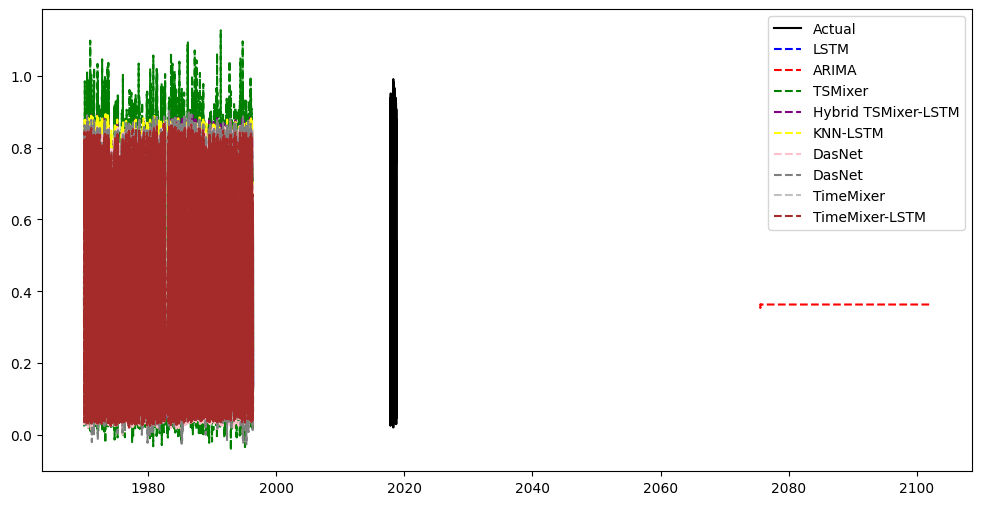

In [30]:
# ========================
# 6️⃣ PLOT MODEL PREDICTIONS
# ========================
plt.figure(figsize=(12, 6))
plt.plot(y_test, label="Actual", color='black')
plt.plot(y_pred_lstm, label="LSTM", linestyle='dashed', color='blue')
plt.plot(y_pred_arima, label="ARIMA", linestyle='dashed', color='red')
plt.plot(y_pred_tsmixer, label="TSMixer", linestyle='dashed', color='green')
plt.plot( y_test_pred, label="Hybrid TSMixer-LSTM", linestyle='dashed', color='purple')
plt.plot(y_pred_knn_lstm, label="KNN-LSTM", linestyle='dashed', color='yellow')
plt.plot(y_pred_actual_Dasnet, label="DasNet", linestyle='dashed', color='pink')
plt.plot(y_pred_Dasnet_LSTM, label="DasNet", linestyle='dashed', color='grey')
plt.plot(y_pred_TimeMixer, label="TimeMixer", linestyle='dashed', color='silver')
plt.plot(y_pred_TimeMixer_LSTM, label="TimeMixer-LSTM", linestyle='dashed', color='brown')
plt.legend()
plt.show()



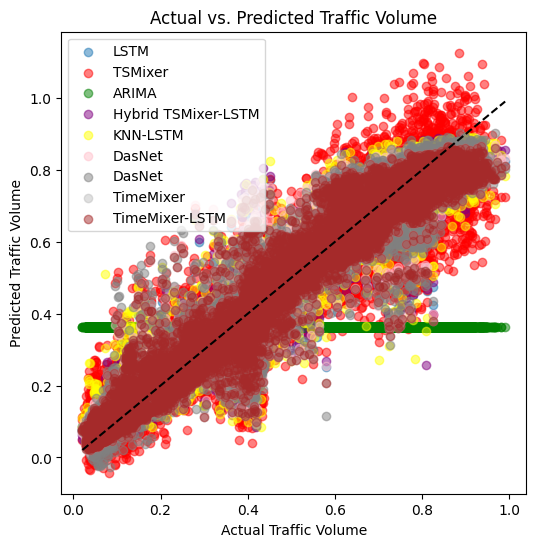

In [31]:
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred_lstm, alpha=0.5, label="LSTM")
plt.scatter(y_test, y_pred_tsmixer, alpha=0.5, label="TSMixer", color='red')
plt.scatter(y_test, y_pred_arima, alpha=0.5, label="ARIMA", color='green')
plt.scatter(y_test, y_test_pred, alpha=0.5, label="Hybrid TSMixer-LSTM", color='purple')
plt.scatter(y_test, y_pred_knn_lstm, alpha=0.5, label="KNN-LSTM", color='yellow')
plt.scatter(y_test, y_pred_actual_Dasnet, alpha=0.5, label="DasNet", color='pink')
plt.scatter(y_test, y_pred_Dasnet_LSTM, alpha=0.5, label="DasNet", color='grey')
plt.scatter(y_test, y_pred_TimeMixer, alpha=0.5, label="TimeMixer", color='silver')
plt.scatter(y_test, y_pred_TimeMixer_LSTM, alpha=0.5, label="TimeMixer-LSTM", color='brown')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='black')  # Ideal fit line
plt.legend()
plt.title("Actual vs. Predicted Traffic Volume")
plt.xlabel("Actual Traffic Volume")
plt.ylabel("Predicted Traffic Volume")
plt.show()


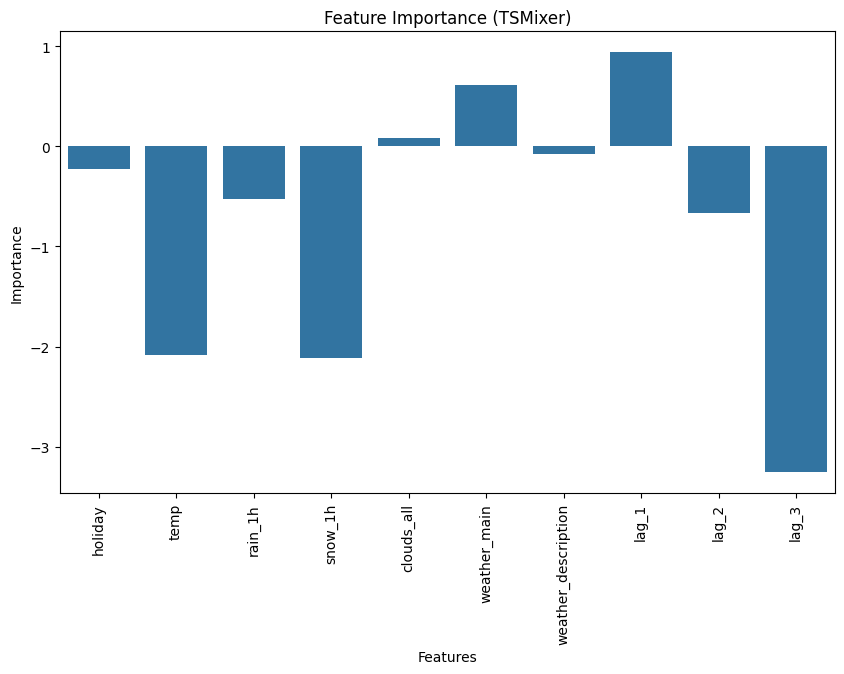

In [ ]:
import seaborn as sns
importance = tsmixer_model.fc1.weight.detach().numpy().sum(axis=0)  # Example for TSMixer
plt.figure(figsize=(10, 6))
sns.barplot(x=X_train.columns, y=importance)
plt.xticks(rotation=90)
plt.title("Feature Importance (TSMixer)")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.show()

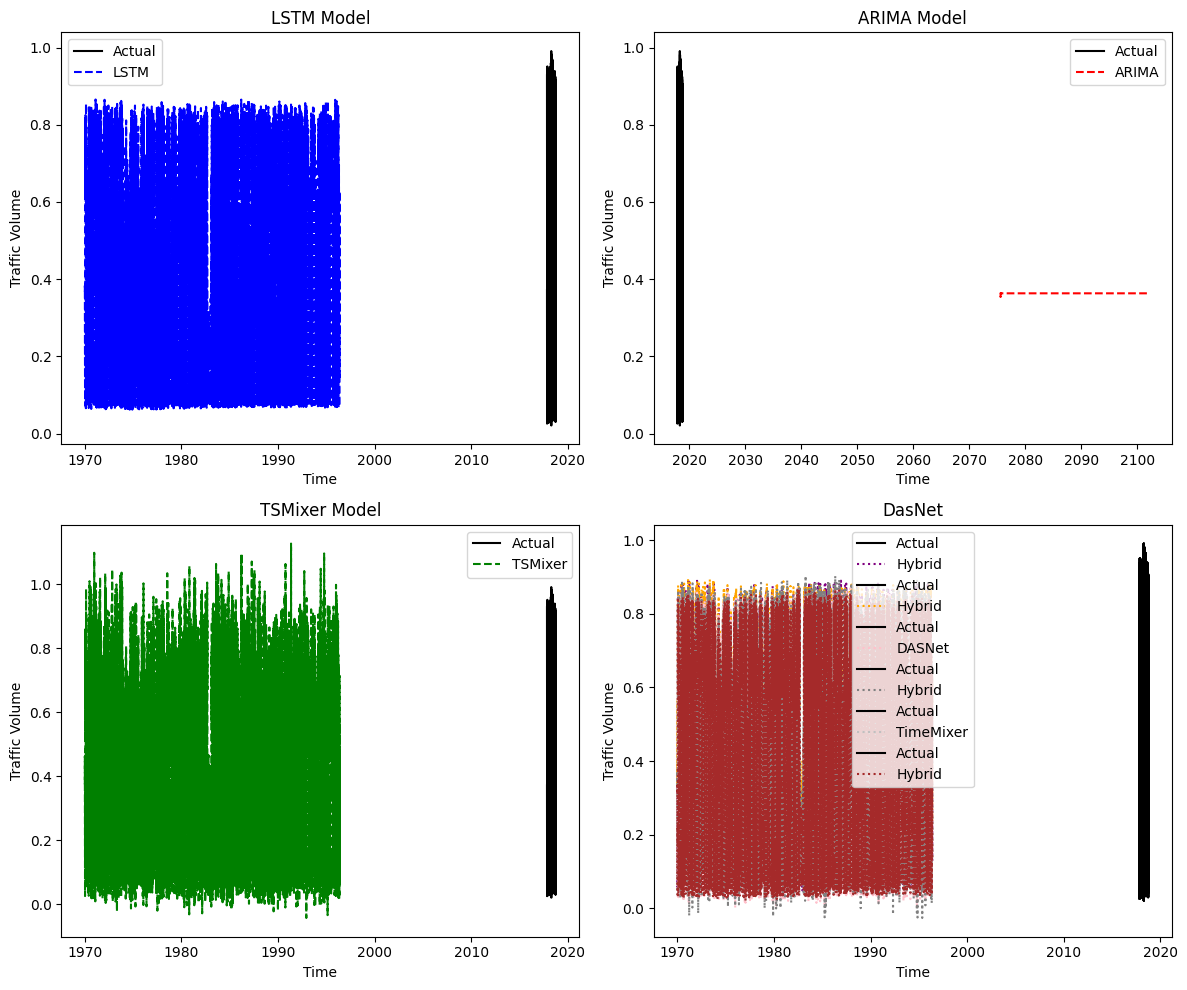

In [32]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

axes[0, 0].plot(y_test, label="Actual", color='black')
axes[0, 0].plot(y_pred_lstm, label="LSTM", linestyle='dashed', color='blue')
axes[0, 0].set_title("LSTM Model")

axes[0, 1].plot(y_test, label="Actual", color='black')
axes[0, 1].plot(y_pred_arima, label="ARIMA", linestyle='dashed', color='red')
axes[0, 1].set_title("ARIMA Model")

axes[1, 0].plot(y_test, label="Actual", color='black')
axes[1, 0].plot(y_pred_tsmixer, label="TSMixer", linestyle='dashed', color='green')
axes[1, 0].set_title("TSMixer Model")

axes[1, 1].plot(y_test, label="Actual", color='black')
axes[1, 1].plot(y_test_pred, label="Hybrid", linestyle='dotted', color='purple')
axes[1, 1].set_title("Hybrid TSMixer-LSTM")

axes[1, 1].plot(y_test, label="Actual", color='black')
axes[1, 1].plot(y_pred_knn_lstm, label="Hybrid", linestyle='dotted', color='orange')
axes[1, 1].set_title("KNN LTM")

axes[1, 1].plot(y_test, label="Actual", color='black')
axes[1, 1].plot(y_pred_actual_Dasnet, label="DASNet", linestyle='dotted', color='pink')
axes[1, 1].set_title("DasNet")


axes[1, 1].plot(y_test, label="Actual", color='black')
axes[1, 1].plot(y_pred_Dasnet_LSTM, label="Hybrid", linestyle='dotted', color='grey')
axes[1, 1].set_title("DasNet")

axes[1, 1].plot(y_test, label="Actual", color='black')
axes[1, 1].plot(y_pred_TimeMixer, label="TimeMixer", linestyle='dotted', color='silver')
axes[1, 1].set_title("TimeMixer")
axes[1, 1].plot(y_test, label="Actual", color='black')
axes[1, 1].plot(y_pred_TimeMixer_LSTM, label="Hybrid", linestyle='dotted', color='brown')
axes[1, 1].set_title("DasNet")




for ax in axes.flat:
    ax.legend()
    ax.set_xlabel("Time")
    ax.set_ylabel("Traffic Volume")

plt.tight_layout()
plt.show()


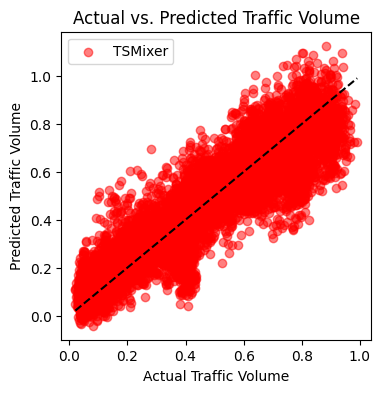

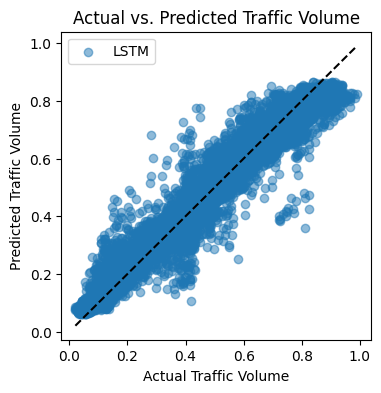

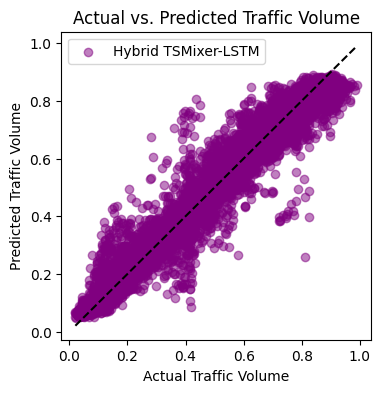

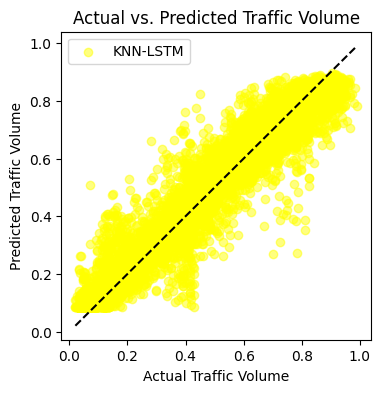

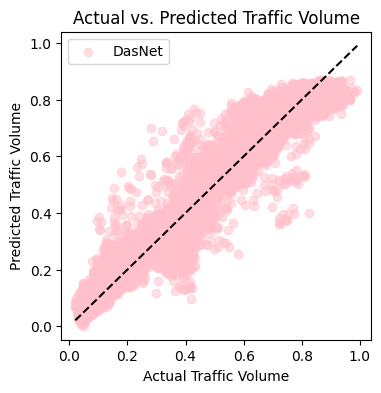

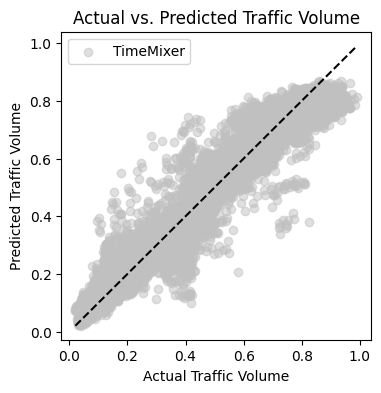

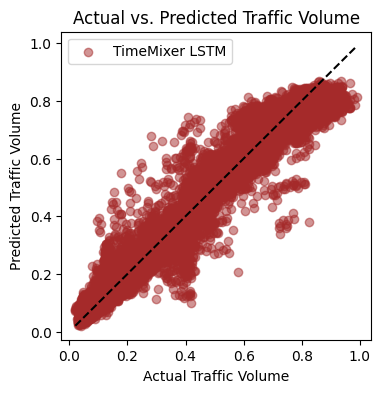

In [33]:
plt.figure(figsize=(4, 4))
plt.scatter(y_test, y_pred_tsmixer, alpha=0.5, label="TSMixer", color='red')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='black')  # Ideal fit line
plt.legend()
plt.title("Actual vs. Predicted Traffic Volume")
plt.xlabel("Actual Traffic Volume")
plt.ylabel("Predicted Traffic Volume")
plt.show()

plt.figure(figsize=(4, 4))
plt.scatter(y_test, y_pred_lstm, alpha=0.5, label="LSTM")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='black')  # Ideal fit line
plt.legend()
plt.title("Actual vs. Predicted Traffic Volume")
plt.xlabel("Actual Traffic Volume")
plt.ylabel("Predicted Traffic Volume")
plt.show()

plt.figure(figsize=(4, 4))
plt.scatter(y_test, y_test_pred, alpha=0.5, label="Hybrid TSMixer-LSTM", color='purple')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='black')  # Ideal fit line
plt.legend()
plt.title("Actual vs. Predicted Traffic Volume")
plt.xlabel("Actual Traffic Volume")
plt.ylabel("Predicted Traffic Volume")
plt.show()

plt.figure(figsize=(4, 4))
plt.scatter(y_test, y_pred_knn_lstm, alpha=0.5, label="KNN-LSTM", color='yellow')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='black')  # Ideal fit line
plt.legend()
plt.title("Actual vs. Predicted Traffic Volume")
plt.xlabel("Actual Traffic Volume")
plt.ylabel("Predicted Traffic Volume")
plt.show()

plt.figure(figsize=(4, 4))
plt.scatter(y_test, y_pred_actual_Dasnet, alpha=0.5, label="DasNet", color='pink')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='black')  # Ideal fit line
plt.legend()
plt.title("Actual vs. Predicted Traffic Volume")
plt.xlabel("Actual Traffic Volume")
plt.ylabel("Predicted Traffic Volume")
plt.show()

plt.figure(figsize=(4, 4))
plt.scatter(y_test, y_pred_TimeMixer, alpha=0.5, label="TimeMixer", color='silver')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='black')  # Ideal fit line
plt.legend()
plt.title("Actual vs. Predicted Traffic Volume")
plt.xlabel("Actual Traffic Volume")
plt.ylabel("Predicted Traffic Volume")
plt.show()


plt.figure(figsize=(4, 4))
plt.scatter(y_test, y_pred_TimeMixer_LSTM, alpha=0.5, label="TimeMixer LSTM", color='brown')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='black')  # Ideal fit line
plt.legend()
plt.title("Actual vs. Predicted Traffic Volume")
plt.xlabel("Actual Traffic Volume")
plt.ylabel("Predicted Traffic Volume")
plt.show()